# Artigo 5 - Kidney Stones

## Objetivo
Para esse quinto artigo, o objetivo é colocar em prática os conhecimentos da [lição 5](https://course.fast.ai/Lessons/lesson5.html) que se trata do processo de criação de um modelo do zero, que utilizara dados tabulares, que nesse caso, se pretende especificamente predizer cálculos renais baseados em dados da urina de um paciente, sendo que esse dado pode ser encontrado na competição [Binary Classification with a Tabular Kidney Stone Prediction Dataset](https://www.kaggle.com/competitions/playground-series-s3e12/overview). Além de no final realizar a sua exportação e o disponibilizar no Hugging Face.

## Motivação

É muito importante prevenir contra os cálculos renais, uma vez que podem causar grande desconforto para a pessoa que a tenha, e ter um modelo que ajude a prever se uma pessoa tem ou não, será de grande ajuda para sua rápida identificação e rápido combate.

## Requisitos
Para poder realizar essa tarefa, é necessário os dados disponibilizados na competição [Binary Classification with a Tabular Kidney Stone Prediction Dataset](https://www.kaggle.com/competitions/playground-series-s3e12/overview), e de todas as bibliotecas que serão utilizadas para a manipulação dos dados, como da criação do modelo, que podem ser encontradas na célula 01.

In [1]:
from pathlib import Path #Path para poder manipular caminhos de arquivos
import torch #Torch para poder criar os tensores
from torch import tensor #Pytorch para cálculos e criar o modelo
import torch.nn.functional as F #F para usar a Relu
import numpy as np #Numpy para poder realziar cálculos
import pandas as pd #Pandas para manipular os dados tabulares
from fastai.data.transforms import RandomSplitter #RandomSplitter para dividir dados entre dados de treino e validação
import sympy #Sympy para poder exemplificar a sigmoid
import pickle #Pickle para poder exportar os coeficientes

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Antes de prosseguir, é interessante fazer uma pequena configuração na exibição dos dados por parte de cada uma dessas bibliotecas, uma vez que pode ser que os dados apresentam várias colunas, onde por isso seja necessário um espaço maior para exibir todas elas, essa configuração pode ser observada na célula 02.

In [2]:
np.set_printoptions(linewidth=140)
torch.set_printoptions(linewidth=140, sci_mode=False, edgeitems=7)
pd.set_option('display.width', 140)

## Dados
Se tendo todas as bibliotecas, agora pode-se começar a mexer com os dados, sendo a primeira coisa necessária, fazer seu download da competição, que foi feito de forma manual e colocado dentro do diretório do Kaggle.

Agora, pode-se pegar o caminho do diretório para começar a visualizar os dados, como mostrado na célula 03.

In [3]:
path = Path('../input/kidney-stone')

df = pd.read_csv(path/'train.csv')
df

,id,gravity,ph,osmo,cond,urea,calc,target
0,0,1.013,6.19,443,14.8,124,1.45,0
1,1,1.025,5.40,703,23.6,394,4.18,0
2,2,1.009,6.13,371,24.5,159,9.04,0
3,3,1.021,4.91,442,20.8,398,6.63,1
4,4,1.021,5.53,874,17.8,385,2.21,1
...,...,...,...,...,...,...,...,...
409,409,1.011,5.21,527,21.4,75,1.53,0
410,410,1.024,5.53,577,19.7,224,0.77,0
411,411,1.018,6.28,455,22.2,270,7.68,1
412,412,1.008,7.12,325,12.6,75,1.03,1


### Manipulação dos Dados
Tendo os dados exibidos, pode-se começar a fazer operações sobre ele para ficar na melhor forma para ser usado para realizar um treinamento de um modelo.

Para isso o primeiro passo é começar verificando dados que são NaN(Not a Number), observável na célula 04.

In [4]:
df.isna().sum()

id         0
gravity    0
ph         0
osmo       0
cond       0
urea       0
calc       0
target     0
dtype: int64

Como se pode observar o dado não possui nenhum NaN(Not a Number), então ele não irá necessitar realizar algum tratamento para esse tipo de situação, sendo assim pode-se continuar a analisar o dado para fazer algum tipo de tratamento.

Para visualizar se existe alguma coluna que mereça atenção se pode utilizar a função de descrição da biblioteca pandas para visualizar as colunas de uma forma melhor, observável na célula 05.

In [5]:
df.describe(include=(np.number))

,id,gravity,ph,osmo,cond,urea,calc,target
count,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000,414.000000
mean,206.500000,1.017894,5.955459,651.545894,21.437923,278.657005,4.114638,0.444444
std,119.655756,0.006675,0.642260,234.676567,7.514750,136.442249,3.217641,0.497505
min,0.000000,1.005000,4.760000,187.000000,5.100000,10.000000,0.170000,0.000000
25%,103.250000,1.012000,5.530000,455.250000,15.500000,170.000000,1.450000,0.000000
50%,206.500000,1.018000,5.740000,679.500000,22.200000,277.000000,3.130000,0.000000
75%,309.750000,1.022000,6.280000,840.000000,27.600000,385.000000,6.630000,1.000000
max,413.000000,1.040000,7.940000,1236.000000,38.000000,620.000000,14.340000,1.000000


Com isso se observa que existem duas colunas que atingem valores bem altos, e para observar melhor nas células 06 e 07 traz um histograma desses dados.

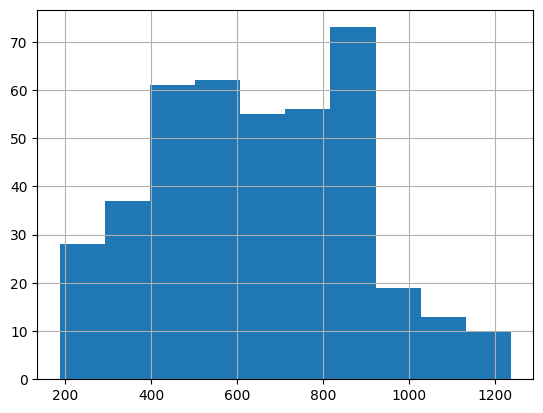

In [6]:
df['osmo'].hist();

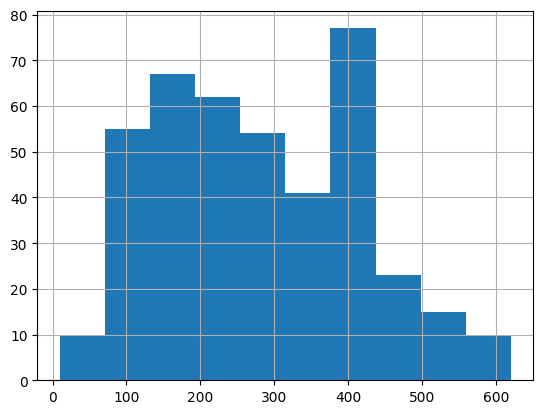

In [7]:
df['urea'].hist();

Para cuidar desses valores muito altos, será aplicado uma transformação, sendo o log, o que vai fazer com que eles fiquem mais uniformes e perto dos outros valores das outras colunas, isso pode ser observado na célula 08, e o resultado, nas células 09 e 10.

In [8]:
df['LogOsmo'] = np.log(df['osmo'] + 1)
df['LogUrea'] = np.log(df['urea'] + 1)

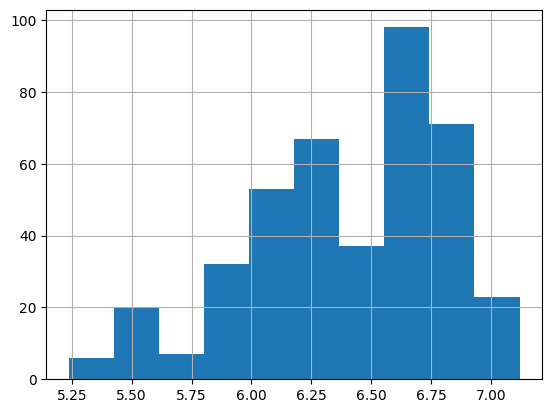

In [9]:
df['LogOsmo'].hist();

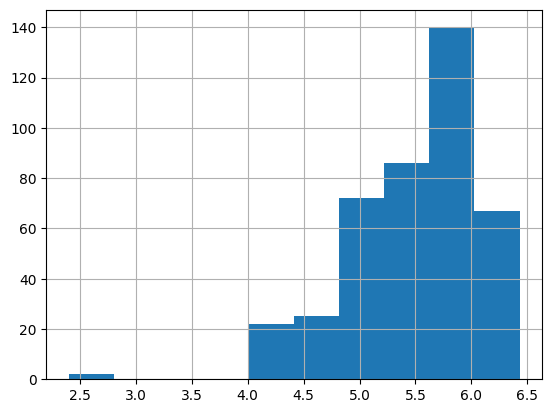

In [10]:
df['LogUrea'].hist();

Diante disso, como não existem colunas categóricas, não há a necessidade de se realizar mais transformações nos dados, então agora eles podem ser observados uma última vez antes que comece os processos para serem tratados para serem apresentados para o modelo, isso pode ser observado na célula 11.

In [11]:
df.columns

Index(['id', 'gravity', 'ph', 'osmo', 'cond', 'urea', 'calc', 'target', 'LogOsmo', 'LogUrea'], dtype='object')

Agora, para ficar mais fácil separar futuramente as colunas de variáveis independentes, elas serão separadas agora manualmente, em uma variável, que pode ser encontrada na célula 12.

In [12]:
separed_cols = ['gravity', 'ph', 'LogOsmo', 'cond', 'LogUrea', 'calc']

### Divisão dos dados
Agora com os dados devidamente tratados, é necessário fazer a divisão entre aqueles que serão usados para o treinamento e aquele que tentara ser predito, para isso é necessário ser de um tipo que permite realizar cálculos sobre ele, e para isso, ambos serão transformados em Tensores, como pode ser observado na célula 13 e 14, e na 15 se observa o tamanho da tabela.

In [13]:
t_dep = tensor(df.target)
t_dep

tensor([0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
        0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0,
        1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0,
        1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0,
        0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0,
        0, 1, 0, 0, 

In [14]:
#separed_cols são as colunas de variáveis independentes

t_indep = tensor(df[separed_cols].values, dtype=torch.float)
t_indep

tensor([[ 1.0130,  6.1900,  6.0958, 14.8000,  4.8283,  1.4500],
        [ 1.0250,  5.4000,  6.5568, 23.6000,  5.9789,  4.1800],
        [ 1.0090,  6.1300,  5.9189, 24.5000,  5.0752,  9.0400],
        [ 1.0210,  4.9100,  6.0936, 20.8000,  5.9890,  6.6300],
        [ 1.0210,  5.5300,  6.7742, 17.8000,  5.9558,  2.2100],
        [ 1.0250,  6.9000,  6.8544, 28.4000,  5.9814,  2.6400],
        [ 1.0080,  5.0900,  5.9189, 15.5000,  5.0752,  2.1700],
        ...,
        [ 1.0140,  5.6800,  6.6201, 29.0000,  5.3613,  3.0400],
        [ 1.0240,  5.6800,  6.7742, 29.0000,  5.9428,  8.9400],
        [ 1.0110,  5.2100,  6.2691, 21.4000,  4.3307,  1.5300],
        [ 1.0240,  5.5300,  6.3596, 19.7000,  5.4161,  0.7700],
        [ 1.0180,  6.2800,  6.1225, 22.2000,  5.6021,  7.6800],
        [ 1.0080,  7.1200,  5.7869, 12.6000,  4.3307,  1.0300],
        [ 1.0110,  6.1300,  5.8999,  9.9000,  5.0752,  0.2700]])

In [15]:
t_indep.shape

torch.Size([414, 6])

## Modelo Linear
Agora com os dados separados, pode-se começar a mexer com um modelo linear, fazendo todo o processo de treinamento até a previsão, que vão ser demostrados nas próximas células.

A primeira coisa que se tem que ter em mente, é que o modelo funciona com coeficientes multiplicados por cada valor de uma linha em uma coluna correspondente da tabela para chegar a sua predição, sendo assim, é necessário se chegar nos melhores valores de coeficientes, mas em um primeiro momento, se parte de coeficientes randômicos e depois, vão sendo ajustados, esse primeiro passo pode ser observado na célula 16.

In [16]:
torch.manual_seed(42) #Essa seed é para quando esse notebook ser executado em outras máquinas produzir os mesmos resultados

n_coeff = t_indep.shape[1]
coeffs = torch.rand(n_coeff) - 0.5 #0.5 serve para centralizr os valores entre -0.5 e 0.5
coeffs

tensor([ 0.3823,  0.4150, -0.1171,  0.4593, -0.1096,  0.1009])

Agora, pode-se observar como se comportara as variáveis dependentes ao serem multiplicas pelos coeficientes de cada coluna respectivamente, podendo ser observado na célula 17.

In [17]:
t_indep*coeffs

tensor([[ 0.3872,  2.5689, -0.7140,  6.7977, -0.5290,  0.1463],
        [ 0.3918,  2.2410, -0.7680, 10.8396, -0.6550,  0.4217],
        [ 0.3857,  2.5440, -0.6933, 11.2530, -0.5560,  0.9121],
        [ 0.3903,  2.0377, -0.7138,  9.5536, -0.6561,  0.6689],
        [ 0.3903,  2.2950, -0.7935,  8.1756, -0.6525,  0.2230],
        [ 0.3918,  2.8635, -0.8029, 13.0443, -0.6553,  0.2664],
        [ 0.3853,  2.1124, -0.6933,  7.1192, -0.5560,  0.2189],
        ...,
        [ 0.3876,  2.3572, -0.7755, 13.3199, -0.5873,  0.3067],
        [ 0.3914,  2.3572, -0.7935, 13.3199, -0.6510,  0.9020],
        [ 0.3865,  2.1622, -0.7343,  9.8291, -0.4744,  0.1544],
        [ 0.3914,  2.2950, -0.7449,  9.0483, -0.5933,  0.0777],
        [ 0.3892,  2.6062, -0.7172, 10.1966, -0.6137,  0.7749],
        [ 0.3853,  2.9548, -0.6779,  5.7873, -0.4744,  0.1039],
        [ 0.3865,  2.5440, -0.6911,  4.5471, -0.5560,  0.0272]])

Pode se observar que existem valores muito grandes, como também valores pequenos, para resolver essa variância, esses valores vão ser normalizados ao se dividir cada um pelo valor máximo da coluna respectiva, fazendo com que assuma valores de 0 a 1, processo esse que pode ser encontrado na célula 18, depois seu comportamento será obsrvado novamente na célula 19.

In [18]:
vals, indices = t_indep.max(dim=0)
t_indep = t_indep / vals

In [19]:
t_indep*coeffs

tensor([[ 0.3723,  0.3235, -0.1003,  0.1789, -0.0822,  0.0102],
        [ 0.3768,  0.2822, -0.1079,  0.2853, -0.1018,  0.0294],
        [ 0.3709,  0.3204, -0.0974,  0.2961, -0.0865,  0.0636],
        [ 0.3753,  0.2566, -0.1002,  0.2514, -0.1020,  0.0466],
        [ 0.3753,  0.2890, -0.1114,  0.2151, -0.1015,  0.0155],
        [ 0.3768,  0.3606, -0.1128,  0.3433, -0.1019,  0.0186],
        [ 0.3705,  0.2660, -0.0974,  0.1873, -0.0865,  0.0153],
        ...,
        [ 0.3727,  0.2969, -0.1089,  0.3505, -0.0913,  0.0214],
        [ 0.3764,  0.2969, -0.1114,  0.3505, -0.1012,  0.0629],
        [ 0.3716,  0.2723, -0.1031,  0.2587, -0.0738,  0.0108],
        [ 0.3764,  0.2890, -0.1046,  0.2381, -0.0923,  0.0054],
        [ 0.3742,  0.3282, -0.1007,  0.2683, -0.0954,  0.0540],
        [ 0.3705,  0.3721, -0.0952,  0.1523, -0.0738,  0.0072],
        [ 0.3716,  0.3204, -0.0971,  0.1197, -0.0865,  0.0019]])

Agora pode-se ver as primeiras predições desse modelo linear com os coeficientes aleatórios, fazendo o somatório das colunas de cada linha específica, observado na célula 20.

In [20]:
preds = (t_indep*coeffs).sum(axis=1)
preds[:10]

tensor([0.7024, 0.7640, 0.8672, 0.7277, 0.6821, 0.8846, 0.6553, 0.5801, 0.8675, 0.8157])

Essas predições ainda não servem, pois foram geradas por coeficientes aleatórios, mas antes que possamos ajustá-las com o gradiente, é necessário saber sua perda, para isso uma boa função pode ser observada na célula 21, que é o valor absoluto da diferença entre a previsão e a variável dependente.

In [21]:
loss = torch.abs(preds - t_dep).mean()
loss

tensor(0.5115)

Agora com isso se tem tudo o que precisa para começar a utilizar o gradiente e treinar de fato o modelo, mas antes de continuar, para facilitar esse processo serão encapsulados esses cálculos em duas funções que podem ser encontradas na célula 22.

In [22]:
def calc_preds(coeffs, indeps): return (indeps * coeffs).sum(axis=1)
def calc_loss(coeffs, indeps, deps): return torch.abs(calc_preds(coeffs, indeps) - deps).mean()

### Ativando Gradiente
Agora se tendo a função de loss, pode-se ativar o gradiente para começar o processo de aprendizado, que consiste em modificar os coeficientes para fazer com que se ajustem da melhor forma para realizar a predição, ao ser ativado o PyTorch acompanhará todas as etapas, isso pode ser começado a ser observado na célula 23.

In [23]:
coeffs.requires_grad_()

tensor([ 0.3823,  0.4150, -0.1171,  0.4593, -0.1096,  0.1009], requires_grad=True)

Agora com ele ativado, pode-se calcular o loss novamente, usando a função definida. Isso pode ser observado na célula 24.

In [24]:
loss = calc_loss(coeffs, t_indep, t_dep)
loss

tensor(0.5115, grad_fn=<MeanBackward0>)

Com isso, pode-se chamar a função que aparece no loss, para ter o gradiente, isso pode ser observado na célula 25.

In [25]:
loss.backward()

Com os gradientes obtidos, pode-se realizar a primeira época do modelo linear, utilizando dos gradientes para poder modificar os coeficientes, lembrando que isso se deve fazer sem o gradiente ativado para não demandar poder computacional a mais do que o necessário. Também se deve definir uma taxa de aprendizado, que pode ser achada por experimentação, nesse caso será mantido a apresentada na [lição 5](https://course.fast.ai/Lessons/lesson5.html), isso pode ser observado na célula 26.

In [26]:
with torch.no_grad():
    coeffs.sub_(coeffs.grad *0.1)
    print(calc_loss(coeffs, t_indep, t_dep))

tensor(0.5075)


A primeira vista já se pode observar que o loss já diminui com apenas uma época.

Com isso, se tem o necessário para poder começar a treinar de fato o modelo.

### Treinando o Modelo Linear
Nesse momento é importante dividir os dados naqueles que vão ser usados para treino e para validação, e para isso é usado a biblioteca da fastai, como pode ser visto na célula 27, nesse caso, sendo executado uma divisão aleatória dos dados.

In [27]:
trn_split, val_split = RandomSplitter(seed=42)(df)

Como isso resulta apenas nas linhas que vão ser selecionadas para cada categoria, há a necessidade de se criar os dataframes que carregam cada uma dessas linhas, onde sua criação pode ser observada na célula 28.

In [28]:
trn_indep, val_indep = t_indep[trn_split], t_indep[val_split]
trn_dep, val_dep = t_dep[trn_split], t_dep[val_split]

#Observando o tamanho de cada um dos dataframes
len(trn_indep), len(val_indep)

(332, 82)

Agora para facilitar ainda mais a progressão de treinamento do modelo, é bom se criar uma função que faça o update dos coeficientes, e que também realize as épocas, sendo essas encontradas respectivamente nas células 29 e 30.

Também é importante lembrar que o gradiente deve ser zerado, uma vez que com os novos valores um novo gradiente deve ser calculado.

In [29]:
def update_coeffs(coeffs, lr): 
    coeffs.sub_(coeffs.grad * lr)
    coeffs.grad.zero_()

In [30]:
def epoch(coeffs, lr):
    loss = calc_loss(coeffs, trn_indep, trn_dep)
    loss.backward()
    with torch.no_grad(): update_coeffs(coeffs, lr)
    print(f"{loss:.3f}", end="; ")

Tendo essas duas funções, já se tem parte da estrutura do modelo, mas para complementar, é interessante a criação de mais algumas, para que algumas tarefas não necessitem de serem feitas a mão, como, por exemplo, a inicialização dos coeficientes como também uma função que realize mais de uma época por vez, isso pode ser observado na célula 31 e 32.

In [31]:
def init_coeffs(): return (torch.rand(n_coeff)-0.5).requires_grad_()

In [32]:
def train_model(epochs=30, lr=0.01):
    torch.manual_seed(42)
    coeffs = init_coeffs()
    for i in range(epochs): epoch(coeffs, lr=lr)
    return coeffs

Com isso se pode executar uma função só que irá ser responsável por treinar o modelo e retornar o seu loss, isso pode ser observado na célula 33.

In [33]:
#Treinando o modelo com 20 épocas e taxa de aprendizado de 0.02
coeffs = train_model(20, lr=0.02)

0.510; 0.509; 0.509; 0.508; 0.508; 0.507; 0.506; 0.506; 0.505; 0.505; 0.504; 0.503; 0.503; 0.502; 0.502; 0.501; 0.501; 0.500; 0.499; 0.499; 

Com isso, é interessante dar uma olhada nos coeficientes que foram atribuídos a cada variável, para saber se o que está acontecendo é realmente razoável, isso pode ser feito através de uma nova função, demostrado na célula 34.

In [34]:
def show_coeffs(): return dict(zip(separed_cols, coeffs.requires_grad_(False)))
show_coeffs()

{'gravity': tensor(0.3450),
 'ph': tensor(0.3835),
 'LogOsmo': tensor(-0.1466),
 'cond': tensor(0.4488),
 'LogUrea': tensor(-0.1328),
 'calc': tensor(0.1285)}

Com uma breve análise e um pouco de pesquisa se entende que os valores fazem realmente sentido no quesito químico da urina, ou seja, o modelo linear realmente está razoável na atribuição dos coeficientes.

## Acurácia
Com o modelo treinado, agora pode-se calcular sua precisão, para isso através dele serão feitas predições e observadas dentro das métricas definidas os resultados, observando se realmente ele tem uma precisão boa, isso pode ser visto nas células 35 a 37.

In [35]:
preds = calc_preds(coeffs, val_indep)

In [36]:
results = val_dep.bool()==(preds>0.5)
results[:15]

tensor([False,  True, False, False,  True,  True, False,  True, False,  True,  True,  True, False,  True,  True])

O modelo não está ruim, tendo acertado mais do que errado, mas pode melhorar.

In [37]:
results.float().mean()

tensor(0.4634)

A acurácia não foi tão boa quanto se esperava, mas no restante desse notebook um modelo mais complexo será criado e medido novamente a acurácia para ver se é possível melhorá-la.

Com isso em mente, novamente cabe espaço para otimizar essa tarefa e colocá-la em uma função que retorne isso automaticamente, observável na célula 38.

In [38]:
def acc(coeffs): return (val_dep.bool()==(calc_preds(coeffs, val_indep)>0.5)).float().mean()
acc(coeffs)

tensor(0.4634)

### Sigmoid
Em alguns casos, pode ser necessário usar a função Sigmoid para comprimir automaticamente valores em um intervalo desejado, uma vez que isso irá fazer com que os dados estejam melhor representados, sendo assim é bom realizar um teste para ver como o modelo se comporta, isso pode ser observado na célula 39(Predições), na 40(Exemplo da função Sigmoid) e nas células 41 a 44(Redefinindo função para retornar no padrão da sigmoid valores binários de classificação).

In [39]:
preds[:30]

tensor([0.7786, 0.6504, 0.5695, 0.7173, 0.6032, 0.4731, 0.5114, 0.7353, 0.7380, 0.7989, 0.7241, 0.6835, 0.5576, 0.6365, 0.7307, 0.5488,
        0.7026, 0.7306, 0.6836, 0.5479, 0.6233, 0.6900, 0.7335, 0.7591, 0.7723, 0.4779, 0.5270, 0.6569, 0.6517, 0.8169])

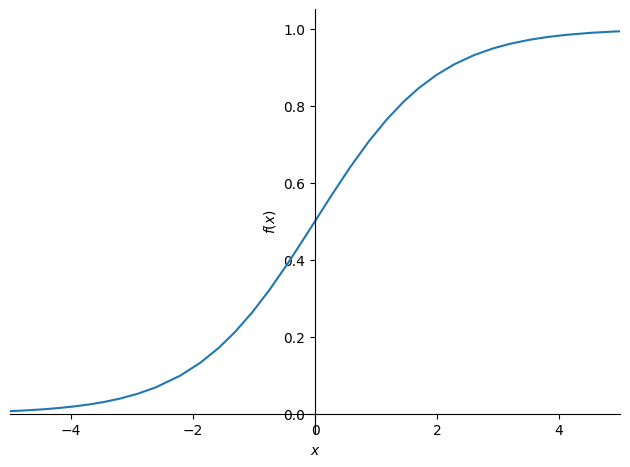

In [40]:
sympy.plot("1/(1 + exp(-x))", xlim=(-5, 5))

In [41]:
def calc_preds(coeffs, indeps): return torch.sigmoid((indeps * coeffs).sum(axis=1))

In [42]:
coeffs = train_model(lr=2)

0.514; 0.511; 0.508; 0.504; 0.501; 0.497; 0.493; 0.490; 0.486; 0.483; 0.480; 0.478; 0.475; 0.473; 0.471; 0.469; 0.468; 0.466; 0.465; 0.464; 0.463; 0.462; 0.461; 0.460; 0.460; 0.459; 0.458; 0.458; 0.457; 0.457; 

In [43]:
acc(coeffs)

tensor(0.5854)

Com uma taxa de aprendizado maior e realizando mais épocas(Como não foi informado usou o valor base de 30) é possível notar que a acurácia do modelo melhorou.

In [44]:
show_coeffs()

{'gravity': tensor(-0.5316),
 'ph': tensor(-0.3742),
 'LogOsmo': tensor(-0.8153),
 'cond': tensor(0.2542),
 'LogUrea': tensor(-0.6300),
 'calc': tensor(0.9953)}

### Multiplicação de Matrizes
Pode se simplificar um pouco mais as funções criadas, para isso, pode se susbstituir alguns cálculos por uma maneira melhor e mais otimizada de se realizar, como pode ser observado nas células seguintes. Sendo na célula 45 a forma básica e na célula 46 sua forma real que será usada nos tensores e na célula 47 a redefinição da função que há ira utilizar.

In [45]:
(val_indep * coeffs).sum(axis=1)

tensor([-1.7869, -1.8966, -1.7499, -1.8447, -1.5602, -1.7905, -1.9503, -1.4586, -1.6298, -1.7837, -1.4029, -1.6991, -1.7222, -1.4877,
        -1.0647, -1.5380, -1.7623, -1.6778, -1.4521, -1.7903, -1.2955, -1.3778, -1.6642, -1.8990, -1.9315, -1.8482, -1.8371, -1.8716,
        -1.6589, -1.5752, -1.6758, -1.4015, -1.4636, -1.7048, -0.9543, -1.7231, -1.8150, -1.6378, -1.7818, -1.4400, -1.7191, -1.7940,
        -1.7596, -1.7562, -1.8244, -1.7821, -1.7814, -1.0741, -1.9588, -1.6626, -1.6426, -1.7939, -1.7193, -1.6940, -1.4816, -1.7245,
        -1.2886, -1.5736, -1.4092, -1.7455, -1.4409, -1.8792, -1.6152, -1.6566, -1.7808, -1.6783, -1.7107, -1.8017, -1.6959, -1.8079,
        -1.8540, -1.8185, -1.8351, -1.4614, -1.8314, -1.7381, -1.8180, -1.4418, -1.6261, -1.7915, -1.6792, -1.8442])

In [46]:
val_indep@coeffs

tensor([-1.7869, -1.8966, -1.7499, -1.8447, -1.5602, -1.7905, -1.9503, -1.4586, -1.6298, -1.7837, -1.4029, -1.6991, -1.7222, -1.4877,
        -1.0647, -1.5380, -1.7623, -1.6778, -1.4521, -1.7903, -1.2955, -1.3778, -1.6642, -1.8990, -1.9315, -1.8482, -1.8371, -1.8716,
        -1.6589, -1.5752, -1.6758, -1.4015, -1.4636, -1.7048, -0.9543, -1.7231, -1.8150, -1.6378, -1.7818, -1.4400, -1.7191, -1.7940,
        -1.7596, -1.7562, -1.8244, -1.7821, -1.7814, -1.0741, -1.9588, -1.6626, -1.6426, -1.7939, -1.7193, -1.6940, -1.4816, -1.7245,
        -1.2886, -1.5736, -1.4092, -1.7455, -1.4409, -1.8792, -1.6152, -1.6566, -1.7808, -1.6783, -1.7107, -1.8017, -1.6959, -1.8079,
        -1.8540, -1.8185, -1.8351, -1.4614, -1.8314, -1.7381, -1.8180, -1.4418, -1.6261, -1.7915, -1.6792, -1.8442])

Se observa os mesmos resultados em ambas.

In [47]:
def calc_preds(coeffs, indeps): return torch.sigmoid(indeps@coeffs)

Se utilizando do que se tem até aqui, e com o desejo de se criar uma rede neural, se tem a necessidade de se colocar mais camadas na rede, sendo que para isso ocorrera a criação de mais de um coeficiente para cada variável, resultando em uma multiplicação de matrizes, sendo que para isso o primeiro passo é ajustar a função que cria os coeficientes, para poder criar uma matriz com uma única coluna, ou seja, um tensor de ordem 1, para que o resultado da multiplicação também retorne uma matriz, isso pode ser observado na célula 48.

In [48]:
def init_coeffs(): return (torch.rand(n_coeff, 1)*0.1).requires_grad_()

Agora também é necessário transformar os dados usados para treinamento e validação para se equiparar com a nova forma que está sendo utilizado para fazer os cálculos, isso pode ser observado na célula 49.

In [49]:
trn_dep = trn_dep[:,None]
val_dep = val_dep[:,None]

A partir disso se pode realizar novamente o processo de treinamento e verificar a acurácia, que caso as transformações estejam certas resultaram nos mesmos valores apresentados no último treinamento(células 42 e 43), isso pode ser observado na célula 50 e 51.

In [50]:
coeffs = train_model(lr=2)

0.505; 0.501; 0.497; 0.494; 0.490; 0.487; 0.484; 0.481; 0.478; 0.476; 0.474; 0.472; 0.470; 0.469; 0.467; 0.466; 0.465; 0.464; 0.463; 0.462; 0.461; 0.461; 0.460; 0.460; 0.459; 0.459; 0.458; 0.458; 0.457; 0.457; 

In [51]:
acc(coeffs)

tensor(0.5854)

É observável que as transformações estão certas, uma vez que os valores foram os mesmos.

## Rede Neural
Agora para criar de fato uma rede neural, é necessário que se adicione as camadas ocultas desejadas, sendo aquelas que ficam entre a camada de entrada e a de saída, na qual também terão seus coeficientes, sendo que o primeiro passo é redefinir a função de inicialização dos coeficientes para criar coeficientes referentes a quantidade de camadas que se deseja, isso pode ser observado na célula 52.

In [52]:
def init_coeffs(n_hidden=20):
    layer1 = (torch.rand(n_coeff, n_hidden) - 0.5)/n_hidden
    layer2 = torch.rand(n_hidden, 1) - 0.3
    const = torch.rand(1)[0]
    return layer1.requires_grad_(), layer2.requires_grad_(), const.requires_grad_()

Agora com essa nova estrutura também é necessário mudar como é calculado as predições e é feito a atualização dos coeficientes, essas novas mudanças podem ser observadas nas células 53 e 54.

In [53]:
def calc_preds(coeffs, indeps):
    l1, l2, const = coeffs
    res = F.relu(indeps@l1)
    res = res@l2 + const
    return torch.sigmoid(res)

In [54]:
def update_coeffs(coeffs, lr):
    for layer in coeffs: layer.sub_(layer.grad * lr)

Agora com tudo isso definido se pode treinar o modelo e observar sua acurácia, sendo demostrado na célula 55 e 56.

In [55]:
coeffs = train_model(lr=1.4)

0.517; 0.514; 0.512; 0.508; 0.502; 0.494; 0.482; 0.471; 0.460; 0.453; 0.451; 0.451; 0.451; 0.452; 0.452; 0.452; 0.452; 0.452; 0.452; 0.452; 0.452; 0.452; 0.452; 0.452; 0.452; 0.452; 0.452; 0.452; 0.452; 0.452; 

In [56]:
acc(coeffs)

tensor(0.5854)

Se observa que a rede neural não apresenta desempenho melhor do que o modelo linear, isso já era esperado, uma vez que o conjunto de dados é simples e pequeno.

## Aprendizado profundo
Até o momento foi criado um modelo com duas camadas, mas para melhorar ainda mais esse modelo e facilitar o trabalho, serão redefinidas novamente as funções de inicialização de coeficientes, cálculo de predições e atualização de coeficientes, a fim de que se possa usá-las para criar um modelo com "n" camadas, isso pode ser observado nas células 57 a 59.

Nesse caso, se criou duas camadas com 10 ativações cada.

In [57]:
def init_coeffs():
    hiddens = [10, 10]
    sizes = [n_coeff] + hiddens + [1]
    n = len(sizes)
    layers = [(torch.rand(sizes[i], sizes[i+1])-0.3)/sizes[i+1]*4 for i in range(n-1)]
    consts = [(torch.rand(1)[0]-0.5)*0.1 for i in range(n-1)]
    for l in layers+consts: l.requires_grad_()
    return layers,consts

In [58]:
def calc_preds(coeffs, indeps):
    layers,consts = coeffs
    n = len(layers)
    res = indeps
    for i,l in enumerate(layers):
        res = res@l + consts[i]
        if i!=n-1: res = F.relu(res)
    return torch.sigmoid(res)

In [59]:
def update_coeffs(coeffs, lr):
    layers,consts = coeffs
    for layer in layers+consts:
        layer.sub_(layer.grad * lr)
        layer.grad.zero_()

Depois de todo esse processo pode se criar novamente o modelo e treiná-lo e assim se tem um modelo de aprendizado profundo e verificar sua acurácia, isso pode ser observado nas células 60 e 61.

In [60]:
coeffs = train_model(lr=4)

0.536; 0.500; 0.497; 0.495; 0.493; 0.491; 0.488; 0.486; 0.484; 0.483; 0.481; 0.479; 0.478; 0.476; 0.475; 0.474; 0.473; 0.472; 0.471; 0.470; 0.469; 0.468; 0.467; 0.467; 0.466; 0.466; 0.465; 0.464; 0.464; 0.464; 

In [61]:
acc(coeffs)

tensor(0.5854)

Nesse caso, pela característica dos dados, o modelo não melhora além do que já se tem, mesmo colocando mais camadas com mais ativações, e aumentando a taxa de aprendizado.

## Exportando
Diante disso se tem um modelo treinado que pode ser exportado para o Hugging Face para ser amplamente utilizado, esse processo de da pela célula 62 e o link da aplicação pode ser encontrado em [Kidney Stones](https://huggingface.co/spaces/fastaioncampus/Kidney-Stones)

In [62]:
with open('Kidney_stones.pkl', 'wb') as arquivo:
    pickle.dump(coeffs, arquivo)